CODE BLOCK: 1

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_7")

In [3]:
from utils import plot_samples, plot_accuracy_metrics
from models import *

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


CODE BLOCK: 2

In [5]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 3

In [6]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [7]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
# train_data = datasets.MNIST('../data', train=True, download=True)
# test_data = datasets.MNIST('../data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 182711828.91it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 125529216.40it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 56202085.24it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21722381.72it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [8]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

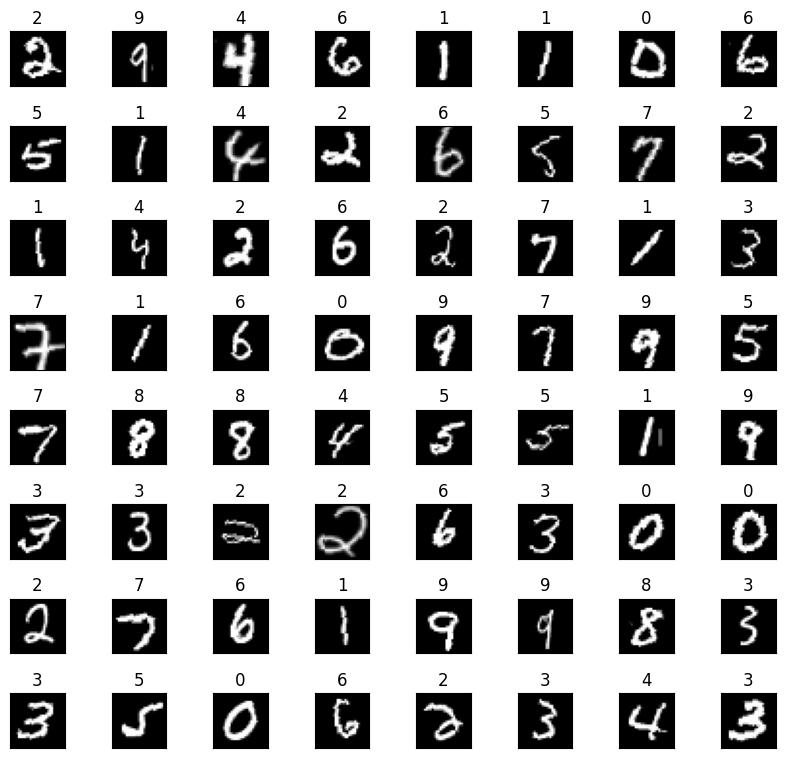

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples(batch_data,batch_label)

In [10]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model_4().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,320
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             136
           Dropout-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,168
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
           Conv2d-13             [-1, 16, 8, 8]           2,320
             ReLU-14             [-1, 1

CODE BLOCK: 8

In [11]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [12]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=0.4306 Batch_id=117 Accuracy=71.18: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


Test set: Average loss: 0.3158, Accuracy: 56085/60000 (93.47%)

Epoch 2


Train: Loss=0.1545 Batch_id=117 Accuracy=94.51: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


Test set: Average loss: 0.1489, Accuracy: 57791/60000 (96.32%)

Epoch 3


Train: Loss=0.1631 Batch_id=117 Accuracy=96.45: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.1005, Accuracy: 58472/60000 (97.45%)

Epoch 4


Train: Loss=0.1040 Batch_id=117 Accuracy=97.03: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Test set: Average loss: 0.0878, Accuracy: 58577/60000 (97.63%)

Epoch 5


Train: Loss=0.0959 Batch_id=117 Accuracy=97.43: 100%|██████████| 118/118 [00:21<00:00,  5.52it/s]


Test set: Average loss: 0.0784, Accuracy: 58645/60000 (97.74%)

Epoch 6


Train: Loss=0.0355 Batch_id=117 Accuracy=97.59: 100%|██████████| 118/118 [00:21<00:00,  5.61it/s]


Test set: Average loss: 0.0641, Accuracy: 58892/60000 (98.15%)

Epoch 7


Train: Loss=0.1160 Batch_id=117 Accuracy=97.72: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


Test set: Average loss: 0.0576, Accuracy: 58989/60000 (98.31%)

Epoch 8


Train: Loss=0.0644 Batch_id=117 Accuracy=97.86: 100%|██████████| 118/118 [00:21<00:00,  5.37it/s]


Test set: Average loss: 0.0565, Accuracy: 58997/60000 (98.33%)

Epoch 9


Train: Loss=0.0668 Batch_id=117 Accuracy=98.02: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Test set: Average loss: 0.0535, Accuracy: 59087/60000 (98.48%)

Epoch 10


Train: Loss=0.0825 Batch_id=117 Accuracy=98.08: 100%|██████████| 118/118 [00:22<00:00,  5.13it/s]


Test set: Average loss: 0.0478, Accuracy: 59154/60000 (98.59%)

Epoch 11


Train: Loss=0.0307 Batch_id=117 Accuracy=98.18: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Test set: Average loss: 0.0462, Accuracy: 59152/60000 (98.59%)

Epoch 12


Train: Loss=0.0559 Batch_id=117 Accuracy=98.26: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0462, Accuracy: 59157/60000 (98.59%)

Epoch 13


Train: Loss=0.0534 Batch_id=117 Accuracy=98.22: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0421, Accuracy: 59236/60000 (98.73%)

Epoch 14


Train: Loss=0.0756 Batch_id=117 Accuracy=98.42: 100%|██████████| 118/118 [00:22<00:00,  5.24it/s]


Test set: Average loss: 0.0459, Accuracy: 59166/60000 (98.61%)

Epoch 15


Train: Loss=0.0422 Batch_id=117 Accuracy=98.33: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Test set: Average loss: 0.0392, Accuracy: 59321/60000 (98.87%)

Epoch 16


Train: Loss=0.0672 Batch_id=117 Accuracy=98.43: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


Test set: Average loss: 0.0375, Accuracy: 59309/60000 (98.85%)

Epoch 17


Train: Loss=0.0530 Batch_id=117 Accuracy=98.48: 100%|██████████| 118/118 [00:22<00:00,  5.34it/s]


Test set: Average loss: 0.0372, Accuracy: 59310/60000 (98.85%)

Epoch 18


Train: Loss=0.0320 Batch_id=117 Accuracy=98.50: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


Test set: Average loss: 0.0360, Accuracy: 59341/60000 (98.90%)

Epoch 19


Train: Loss=0.0110 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


Test set: Average loss: 0.0343, Accuracy: 59370/60000 (98.95%)

Epoch 20


Train: Loss=0.1327 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Test set: Average loss: 0.0342, Accuracy: 59381/60000 (98.97%)



CODE BLOCK: 11

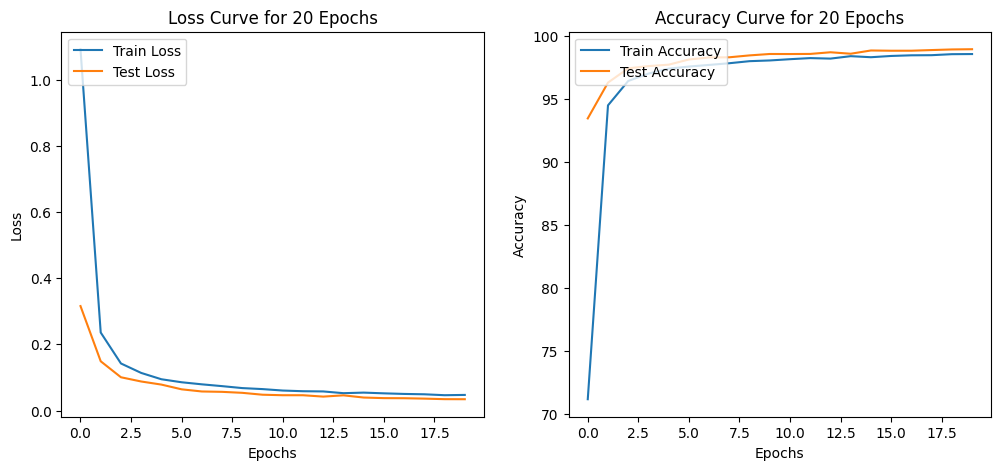

In [14]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc)